## Libraries

In [1]:
import geopandas as gpd
import pandas as pd
from timeit import timeit
from tkinter import NE
import pytest
import multiprocessing 
import numpy as np
from multiprocessing import Pool
import random
from functools import reduce
import time
from shapely.geometry import Point, Polygon
from sentinelhub import *
import os
import json
from functools import wraps
import pytest
import unittest
from unittest import mock
from unittest.mock import patch
from faker import Faker
import datetime as dt
import matplotlib.pyplot as plt
import re
import shutil, tempfile
from os import path
import unittest
import inspect

In [174]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src/data")

In [4]:
import get_rs_data

Let us first do unit testing on the config file

In [5]:
def test_config_type():
    assert isinstance(get_rs_data.get_config(),SHConfig)==True  

This is the unit test for our get_config function where we test if the returned type of the object is SHConfig

#### Function to generate random coordinates

In [5]:
def generate_coor(n,is_seed):
    x=[]
    lat_lng=[]
    n=5
    if is_seed:
        Faker.seed(0)
        fake=Faker()
        for _ in range(n):
            temp=tuple()
            for value in fake.latlng():
                temp=temp + ((float(value)),)
            x.append(temp)
    else:
        fake=Faker()
        for _ in range(n):
            temp=tuple()
            for value in fake.latlng():
                temp=temp + ((float(value)),)
            x.append(temp)
    return x

Let us move to unit testing the min_max coordinate function. We first check if the length of the returned value is 4

In [6]:
def test_min_max_len():
    x=generate_coor(n=5,is_seed=True)
    assert len(get_rs_data.get_min_max(x))==4
test_min_max_len()

Then, we check if the data type of the output is a list

In [7]:
def test_min_max_type():
    x=generate_coor(n=5,is_seed=True)
    assert isinstance(get_rs_data.get_min_max(x),list)==True

This is our expected output based on the seeded coordinate

In [8]:
def test_min_max_value():
    x=generate_coor(n=5,is_seed=True)
    assert get_rs_data.get_min_max(x)==[-79.132557, -40.995129, 47.244262, 80.880444]
test_min_max_value()

We should not input any empty list as the argument so we are testing if our function actually throws a exception

In [9]:
def test_min_max_empty():
    with pytest.raises(Exception) as excinfo:
        get_rs_data.get_min_max([])
    assert str(excinfo.value)=="Sorry, Coordinate is empty!"
         
test_min_max_empty()

These are the unit tests for get_min_max functions

Now, we move on to develop a function that creates a geopandas dataframe which mimickes what we expect from Quartersection shape file

#### function to generate geopandas dataframe

In [10]:
def create_gdf(PPID,EFFDT,FEATURECD,QSECT,PSECTPPID,PSECT,PTWP,PRGE,PMER,geo):
    gdf = gpd.GeoDataFrame(
    {'PPID': PPID,
     'EFFDT': EFFDT,
     'FEATURECD':FEATURECD,
     'QSECT':QSECT,
     'PSECTPPID':PSECTPPID,
     'PSECT':PSECT,
     'PTWP':PTWP,
     'PRGE':PRGE,
     'PMER':PMER,
     'geometry':geo})
    gdf=gdf.set_crs(epsg=4326)
    return gdf

x=create_gdf(["0108002F12"],["20070209"],["THEORETIC"],	["NE"],["0110006APD"],["28"],["68"],["O7"],["02"],Polygon([(628293.35, 6087188.3100000005),
 (627891.065, 6087176.805),
 (627488.78, 6087165.3),
 (627477.36, 6087567.365),
 (627465.94, 6087969.43),
 (627868.15, 6087980.9350000005),
 (628270.36, 6087992.4399999995),
 (628281.855, 6087590.375),
 (628293.35, 6087188.3100000005)]))

This is a unit test to check if the columns were inputed correctly

In [11]:
def test_create_gdf_col():
    loc_gdf=create_gdf([],[],[],[],[],[],[],[],[],[])
    assert list(loc_gdf.columns)==['PPID','EFFDT','FEATURECD','QSECT','PSECTPPID','PSECT','PTWP', 'PRGE','PMER','geometry']
    
test_create_gdf_col()

In [12]:
def test_get_boundary_box_empty_gpd():
    with pytest.raises(Exception) as excinfo:
        get_rs_data.get_boundary_box(None,None,None,None,None,None,x)
    print(str(excinfo.value))
    assert str(excinfo.value)=="Sorry, Dataframe is empty!"
    
test_get_boundary_box_empty_gpd()

Sorry, Dataframe is empty!


In [13]:
def test_get_boundary_box_temp_type():
    assert isinstance(get_rs_data.get_boundary_box("NE","28","68","O7","02",None,gdf=x),list)==True
test_get_boundary_box_temp_type()

In [14]:
def test_get_boundary_box_temp_len():
    assert len(get_rs_data.get_boundary_box("NE","28","68","O7","02",None,gdf=x))==4
test_get_boundary_box_temp_len()

In [15]:
def test_get_boundary_box_temp_value():
    assert get_rs_data.get_boundary_box("NE","28","68","O7","02",None,gdf=x)==[627465.94, 6087165.3, 628293.35, 6087992.4399999995]
test_get_boundary_box_temp_value()

We start unit testing our save data function by first checking if the temporary mocked path actually exists

In [152]:
import shutil, tempfile
from os import path
import unittest

def test_mock_check_path():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    assert os.path.exists(test_dir)==True
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)

We then proceed for checking outputs of the functions. First, we check if any sort of data has been saved at all

In [106]:
def test_mock_check_file_NDTI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDTI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=len(os.listdir(test_dir)) > 0
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True

/tmp/save_datak6py20f_
539


We then check if the json files are there or not

In [211]:
def test_mock_check_file_type_json_NDTI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDTI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=False
    for folder,subfolders,files in os.walk(test_dir):
        for f in files:
            if f.endswith(".json"):
                x=True
                break
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True
test_mock_check_file_type_json_NDTI()

/tmp/save_data6lbm4p32
539


Finally, we check if the image output is there

In [58]:
def test_mock_check_file_type_tiff_NDTI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDTI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=False
    for folder,subfolders,files in os.walk(test_dir):
        for f in files:
            if f.endswith(".tiff"):
                x=True
                break
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True
test_mock_check_file_type_tiff_NDTI()

/tmp/save_datab_p365_k
539


We do the same for layer NDVI

In [107]:
def test_mock_check_file_NDVI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDVI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=len(os.listdir(test_dir)) > 0
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True
test_mock_check_file_NDVI()

/tmp/save_dataksulhwz2
539


In [153]:
def test_mock_check_file_type_json_NDVI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDVI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=False
    for folder,subfolders,files in os.walk(test_dir):
        for f in files:
            if f.endswith(".json"):
                x=True
                break
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True
test_mock_check_file_type_json_NDVI()

/tmp/save_dataj93vcv1c
539


In [110]:
def test_mock_check_file_type_tiff_NDVI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    print(test_dir)
    get_rs_data.save_sh_LETM2_data(get_rs_data.save_LETM2_data(layer='NDTI',bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],start_date="2002-01-01",end_date="2021-12-31",output_folder=test_dir,config=get_rs_data.get_config()))
    print(len(os.listdir(test_dir)))
    x=False
    for folder,subfolders,files in os.walk(test_dir):
        for f in files:
            if f.endswith(".tiff"):
                x=True
                break
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert x==True
test_mock_check_file_type_tiff_NDVI()

/tmp/save_databusv9tf9
539


#### Function to extract date from url

In [133]:
def get_date_url(url):
    date_regex=r"(\d{4}-\d{2}-\d{2})"
    ar_date=re.search(r"TIME=" + date_regex, url).group(1)
    ar_date=dt.datetime.strptime(ar_date,'%Y-%m-%d')
    return ar_date

#### Function to get list of dates from saved data json files


In [138]:
def list_date(dir):
    ar_date_url=[]
    for folder,subfolders,files in os.walk(dir):
        for f in files:
            if f.endswith(".json"):
                name=folder+"/request.json"
                h=open(name)
                data=json.load(h)
                url=data["url"]
                ar_date=get_date_url(url)
                ar_date_url.append(ar_date)
    ar_date_url.sort()
    diff=[(t - s).days for s, t in zip(ar_date_url, ar_date_url[1:])]
    return diff,ar_date_url

#### Function to generate random start and end date 

In [195]:
from faker import Faker
fake=Faker()
def random_st_en():
    start_date=fake.date_time_between(start_date=dt.date(2002,1,1),end_date=dt.date(2014,12,31))
    start_date=start_date.date()
    end_date=fake.date_time_between(start_date=dt.date(2016,1,1),end_date=dt.date(2021,12,31))
    end_date=end_date.date()
    return start_date,end_date

In [187]:
def test_save_data_period_NDTI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    start_date,end_date=random_st_en()
    get_rs_data.save_data_for_periods(start_dates=[str(start_date)],end_dates=[str(end_date)],layer="NDTI",bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],output_folder=test_dir,config=get_rs_data.get_config())
    diff,ar_date=list_date(test_dir)
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert min(ar_date).date()>=start_date and min(ar_date).date()<=end_date
test_save_data_period_NDTI()

In [210]:
def test_save_data_period_NDVI():
    test_dir=tempfile.mkdtemp(prefix="save_data")
    start_date,end_date=random_st_en()
    print(start_date,end_date)
    get_rs_data.save_data_for_periods(start_dates=[str(start_date)],end_dates=[str(end_date)],layer="NDVI",bbox=[-103.01106517317754,54.915193167235394,-102.99851132434331,54.92242167192495],output_folder=test_dir,config=get_rs_data.get_config())
    diff,ar_date=list_date(test_dir)
    shutil.rmtree(test_dir, ignore_errors=False, onerror=None)
    assert min(ar_date).date()>=start_date and min(ar_date).date()<=end_date
test_save_data_period_NDVI()

2005-08-06 2018-08-27


In [206]:
def test_save_data_param():
    assert inspect.getfullargspec(get_rs_data.save_data_for_periods).args==['start_dates', 'end_dates', 'layer', 'bbox', 'output_folder', 'config']
test_save_data_param()

This part of the notebook is for self exploration work and will be removed later


In [139]:
diff,ar_date_url=list_date('/home/ahnaf.ryan/datascience work/sask_ndti_analysis/sask_ndti_analysis/save_data')

Text(0.5, 0, 'Difference between Sorted Acquisition Dates for Period 2002-01-01 to 2021-12-31')

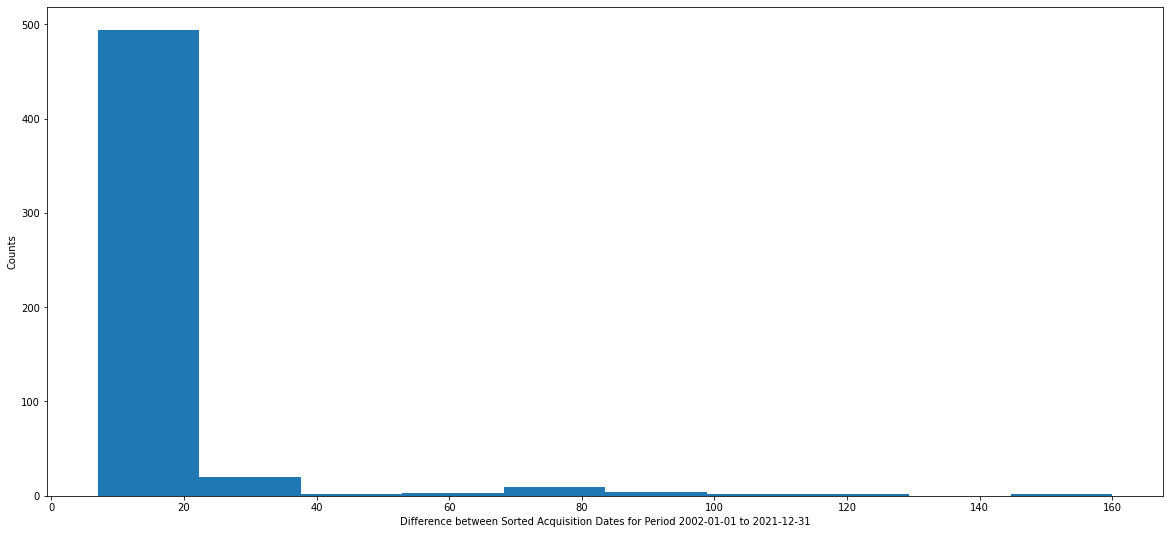

In [146]:
fig, ax = plt.subplots(figsize =(20, 9))
plt.hist(diff,density=False)
plt.ylabel("Counts")
plt.xlabel("Difference between Sorted Acquisition Dates for Period 2002-01-01 to 2021-12-31")

In [ ]:
## do latin cube sampling 

In [2]:
gdf=gpd.read_file("/home/ahnaf.ryan/data_download/SaskGrid_2015_QUARTERSECTION/SaskGrid_2015_QUARTERSECTION.shp")

In [3]:
len(gdf)

991006